In [1]:
# Multinomial Logistic Regression for Supply Chain Risk Classification
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, validation_curve
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_curve, auc, 
                           roc_auc_score, log_loss)
from sklearn.preprocessing import label_binarize
from scipy.stats import uniform, loguniform
import pickle
import warnings
import time
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("🔢 Multinomial Logistic Regression for Supply Chain Risk Classification")
print("=" * 80)
print("Libraries imported successfully!")
print("Starting logistic regression modeling pipeline...")


🔢 Multinomial Logistic Regression for Supply Chain Risk Classification
Libraries imported successfully!
Starting logistic regression modeling pipeline...


In [2]:
# Load Preprocessed Data
print("\n" + "=" * 50)
print("LOADING PREPROCESSED DATA")
print("=" * 50)

try:
    # Load the preprocessed training and test data
    X_train = pd.read_csv('data/X_train_processed.csv')
    X_test = pd.read_csv('data/X_test_processed.csv')
    y_train = pd.read_csv('data/y_train_processed.csv')['risk_classification'].values
    y_test = pd.read_csv('data/y_test_processed.csv')['risk_classification'].values
    
    # Load the label encoder for class name mapping
    with open('label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    
    print(f"✅ Training data loaded: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"✅ Test data loaded: {X_test.shape[0]} samples, {X_test.shape[1]} features")
    print(f"✅ Label encoder loaded successfully")
    
    # 🚨 DATA LEAKAGE DETECTION AND REMOVAL
    print(f"\n⚠️  DATA LEAKAGE DETECTION")
    print("=" * 30)
    
    # Remove disruption_likelihood_score as it causes perfect prediction (data leakage)
    leaky_features = ['disruption_likelihood_score']
    
    print(f"🔍 Checking for data leakage...")
    for feature in leaky_features:
        if feature in X_train.columns:
            print(f"❌ Removing leaky feature: {feature}")
            X_train = X_train.drop(feature, axis=1)
            X_test = X_test.drop(feature, axis=1)
        else:
            print(f"✅ Feature {feature} not found in dataset")
    
    print(f"✅ Data leakage removed!")
    print(f"📊 Final dataset: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    
    # Display class mapping
    class_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
    print(f"\nClass mapping: {class_mapping}")
    
    # Display class distribution
    unique, counts = np.unique(y_train, return_counts=True)
    print("\nTraining set class distribution:")
    for class_idx, count in zip(unique, counts):
        class_name = label_encoder.inverse_transform([class_idx])[0]
        percentage = count / len(y_train) * 100
        print(f"  {class_name} (Class {class_idx}): {count} samples ({percentage:.1f}%)")
    
    print(f"\n🎯 Clean dataset is ready for logistic regression modeling!")
    
except FileNotFoundError as e:
    print(f"❌ Error loading preprocessed data: {e}")
    print("Please run the data preprocessing notebook first to generate the required files.")
except Exception as e:
    print(f"❌ Unexpected error: {e}")



LOADING PREPROCESSED DATA
✅ Training data loaded: 22445 samples, 29 features
✅ Test data loaded: 9620 samples, 29 features
✅ Label encoder loaded successfully

⚠️  DATA LEAKAGE DETECTION
🔍 Checking for data leakage...
❌ Removing leaky feature: disruption_likelihood_score
✅ Data leakage removed!
📊 Final dataset: 22445 samples, 28 features

Class mapping: {0: 'High Risk', 1: 'Low Risk', 2: 'Moderate Risk'}

Training set class distribution:
  High Risk (Class 0): 16760 samples (74.7%)
  Low Risk (Class 1): 2177 samples (9.7%)
  Moderate Risk (Class 2): 3508 samples (15.6%)

🎯 Clean dataset is ready for logistic regression modeling!


In [3]:
# Baseline Multinomial Logistic Regression
print("\n" + "=" * 60)
print("MULTINOMIAL LOGISTIC REGRESSION")
print("=" * 60)

# Start with a baseline Logistic Regression
print("🔢 Step 1: Training Baseline Multinomial Logistic Regression")
print("-" * 55)

# Create baseline logistic regression
# Use multinomial for multi-class classification
lr_baseline = LogisticRegression(
    multi_class='multinomial',  # Use multinomial for 3+ classes
    solver='lbfgs',            # Good solver for multinomial
    random_state=42,
    max_iter=1000              # Increased iterations for convergence
)

print("📊 Model Configuration:")
print(f"   Multi-class: {lr_baseline.multi_class}")
print(f"   Solver: {lr_baseline.solver}")
print(f"   Regularization (C): {lr_baseline.C}")
print(f"   Max iterations: {lr_baseline.max_iter}")

print("\n⏳ Training baseline model...")
start_time = time.time()
lr_baseline.fit(X_train, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred_baseline = lr_baseline.predict(X_test)
y_pred_proba_baseline = lr_baseline.predict_proba(X_test)

# Calculate baseline metrics
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_precision = precision_score(y_test, y_pred_baseline, average='weighted')
baseline_recall = recall_score(y_test, y_pred_baseline, average='weighted')
baseline_f1 = f1_score(y_test, y_pred_baseline, average='weighted')
baseline_log_loss = log_loss(y_test, y_pred_proba_baseline)

print(f"✅ Training completed in {training_time:.2f} seconds!")
print(f"\n📊 Baseline Logistic Regression Results:")
print(f"   Accuracy:  {baseline_accuracy:.4f}")
print(f"   Precision: {baseline_precision:.4f}")
print(f"   Recall:    {baseline_recall:.4f}")
print(f"   F1-Score:  {baseline_f1:.4f}")
print(f"   Log Loss:  {baseline_log_loss:.4f}")

# Model characteristics
print(f"\n🔢 Model Characteristics:")
print(f"   Number of classes: {len(lr_baseline.classes_)}")
print(f"   Number of features: {lr_baseline.coef_.shape[1]}")
print(f"   Coefficient matrix shape: {lr_baseline.coef_.shape}")
print(f"   Converged: {lr_baseline.n_iter_[0] < lr_baseline.max_iter}")
print(f"   Iterations used: {lr_baseline.n_iter_[0]}")

print("\n✅ Baseline model trained successfully!")



MULTINOMIAL LOGISTIC REGRESSION
🔢 Step 1: Training Baseline Multinomial Logistic Regression
-------------------------------------------------------
📊 Model Configuration:
   Multi-class: multinomial
   Solver: lbfgs
   Regularization (C): 1.0
   Max iterations: 1000

⏳ Training baseline model...
✅ Training completed in 0.06 seconds!

📊 Baseline Logistic Regression Results:
   Accuracy:  0.7468
   Precision: 0.5577
   Recall:    0.7468
   F1-Score:  0.6385
   Log Loss:  0.7357

🔢 Model Characteristics:
   Number of classes: 3
   Number of features: 28
   Coefficient matrix shape: (3, 28)
   Converged: True
   Iterations used: 16

✅ Baseline model trained successfully!


In [4]:
# Hyperparameter Tuning for Multinomial Logistic Regression
print("\n🔧 Step 2: Hyperparameter Tuning with RandomizedSearchCV")
print("-" * 60)

# Define parameter distributions for Logistic Regression
print("🎲 Using RandomizedSearchCV for efficient hyperparameter tuning...")
lr_param_dist = {
    'C': loguniform(1e-4, 1e2),              # Regularization strength (log scale)
    'penalty': ['l1', 'l2', 'elasticnet'],   # Regularization type
    'solver': ['liblinear', 'saga'],         # Solvers that support all penalties
    'l1_ratio': uniform(0, 1),               # Elastic net mixing (only for elasticnet)
    'max_iter': [500, 1000, 2000, 3000],     # Maximum iterations
    'tol': loguniform(1e-5, 1e-2)            # Tolerance for stopping criteria
}

print(f"🎲 Testing 30 random parameter combinations")
print(f"📊 Dataset: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"🔄 Cross-validation: 3-fold CV")
print(f"⏱️  Estimated time: 1-2 minutes")
print(f"🎯 Scoring metric: F1-weighted")

start_time = time.time()

# Perform randomized search with cross-validation
print(f"\n⏳ Step 2a: Setting up RandomizedSearchCV...")
lr_random_search = RandomizedSearchCV(
    LogisticRegression(
        multi_class='multinomial',
        random_state=42
    ),
    lr_param_dist,
    n_iter=30,              # Test 30 random combinations
    cv=3,                   # 3-fold CV for speed
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=42,
    verbose=2               # Progress tracking
)

print(f"✅ RandomizedSearchCV configured successfully!")
print(f"⏳ Step 2b: Starting hyperparameter search (30 combinations × 3 CV folds = 90 model fits)...")
print(f"🚀 Training in progress... You'll see progress updates below:")
print("-" * 70)

lr_random_search.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print("-" * 70)
print(f"⏱️  Training completed in {elapsed_time:.1f} seconds ({elapsed_time/60:.1f} minutes)")

# Get the best model
lr_best = lr_random_search.best_estimator_

print(f"✅ RandomizedSearchCV completed!")
print(f"\n🏆 Best Parameters:")
for param, value in lr_random_search.best_params_.items():
    if isinstance(value, float):
        print(f"   {param}: {value:.6f}")
    else:
        print(f"   {param}: {value}")

print(f"\n📊 Best Cross-Validation F1-Score: {lr_random_search.best_score_:.4f}")

# Train the best model and evaluate
print(f"\n⏳ Step 2c: Evaluating optimized model on test set...")
y_pred_best_lr = lr_best.predict(X_test)
y_pred_proba_best_lr = lr_best.predict_proba(X_test)

# Calculate optimized metrics
best_lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
best_lr_precision = precision_score(y_test, y_pred_best_lr, average='weighted')
best_lr_recall = recall_score(y_test, y_pred_best_lr, average='weighted')
best_lr_f1 = f1_score(y_test, y_pred_best_lr, average='weighted')
best_lr_log_loss = log_loss(y_test, y_pred_proba_best_lr)

print(f"\n📈 Optimized Logistic Regression Results:")
print(f"   Accuracy:  {best_lr_accuracy:.4f} (Δ {best_lr_accuracy - baseline_accuracy:+.4f})")
print(f"   Precision: {best_lr_precision:.4f} (Δ {best_lr_precision - baseline_precision:+.4f})")
print(f"   Recall:    {best_lr_recall:.4f} (Δ {best_lr_recall - baseline_recall:+.4f})")
print(f"   F1-Score:  {best_lr_f1:.4f} (Δ {best_lr_f1 - baseline_f1:+.4f})")
print(f"   Log Loss:  {best_lr_log_loss:.4f} (Δ {best_lr_log_loss - baseline_log_loss:+.4f})")

# Optimized model characteristics
print(f"\n🔢 Optimized Model Characteristics:")
print(f"   Regularization (C): {lr_best.C:.6f}")
print(f"   Penalty: {lr_best.penalty}")
print(f"   Solver: {lr_best.solver}")
if lr_best.penalty == 'elasticnet':
    print(f"   L1 Ratio: {lr_best.l1_ratio:.3f}")
print(f"   Max iterations: {lr_best.max_iter}")
print(f"   Tolerance: {lr_best.tol:.6f}")
print(f"   Converged: {lr_best.n_iter_[0] < lr_best.max_iter}")
print(f"   Iterations used: {lr_best.n_iter_[0]}")

print(f"\n🎯 Average time per parameter combination: {elapsed_time/30:.1f}s")



🔧 Step 2: Hyperparameter Tuning with RandomizedSearchCV
------------------------------------------------------------
🎲 Using RandomizedSearchCV for efficient hyperparameter tuning...
🎲 Testing 30 random parameter combinations
📊 Dataset: 22445 samples, 28 features
🔄 Cross-validation: 3-fold CV
⏱️  Estimated time: 1-2 minutes
🎯 Scoring metric: F1-weighted

⏳ Step 2a: Setting up RandomizedSearchCV...
✅ RandomizedSearchCV configured successfully!
⏳ Step 2b: Starting hyperparameter search (30 combinations × 3 CV folds = 90 model fits)...
🚀 Training in progress... You'll see progress updates below:
----------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END C=0.017670169402947963, l1_ratio=0.9507143064099162, max_iter=2000, penalty=l1, solver=liblinear, tol=2.9380279387035334e-05; total time=   0.0s
[CV] END C=0.017670169402947963, l1_ratio=0.9507143064099162, max_iter=2000, penalty=l1, solver=liblinear, tol=2.

In [5]:
# Model Comparison and Evaluation
print("\n" + "=" * 60)
print("MODEL COMPARISON AND EVALUATION")
print("=" * 60)

# Create comprehensive comparison
models_comparison = {
    'Model': ['Baseline Logistic Regression', 'Optimized Logistic Regression'],
    'Accuracy': [baseline_accuracy, best_lr_accuracy],
    'Precision': [baseline_precision, best_lr_precision],
    'Recall': [baseline_recall, best_lr_recall],
    'F1-Score': [baseline_f1, best_lr_f1],
    'Log Loss': [baseline_log_loss, best_lr_log_loss]
}

comparison_df = pd.DataFrame(models_comparison)

print("📊 COMPREHENSIVE MODEL COMPARISON")
print("=" * 50)
print(comparison_df.round(4).to_string(index=False))

# Identify best performing model
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.iloc[best_model_idx]['Model']
best_f1_score = comparison_df.iloc[best_model_idx]['F1-Score']

print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1_score:.4f}")

# Determine which model to use for detailed analysis
if 'Optimized' in best_model_name:
    best_model = lr_best
    best_predictions = y_pred_best_lr
    best_probabilities = y_pred_proba_best_lr
else:
    best_model = lr_baseline
    best_predictions = y_pred_baseline
    best_probabilities = y_pred_proba_baseline

print(f"\n📈 Using {best_model_name} for detailed evaluation...")

# Detailed Classification Report
print("\n" + "=" * 60)
print("DETAILED EVALUATION METRICS")
print("=" * 60)

# Classification Report
print("📋 CLASSIFICATION REPORT")
print("-" * 30)
class_names = label_encoder.classes_
print(classification_report(y_test, best_predictions, target_names=class_names))

# Confusion Matrix
print(f"\n🔍 CONFUSION MATRIX")
print("-" * 20)
cm = confusion_matrix(y_test, best_predictions)
print("Confusion Matrix (Actual vs Predicted):")
print(f"{'':>15} {'Predicted':>30}")
print(f"{'Actual':>10} {' '.join([f'{cls:>10}' for cls in class_names])}")
for i, actual_class in enumerate(class_names):
    row = f"{actual_class:>10} " + " ".join([f"{cm[i][j]:>10}" for j in range(len(class_names))])
    print(row)

# Calculate per-class metrics
print(f"\n📊 PER-CLASS PERFORMANCE ANALYSIS")
print("-" * 35)
for i, class_name in enumerate(class_names):
    class_precision = precision_score(y_test, best_predictions, labels=[i], average=None)[0]
    class_recall = recall_score(y_test, best_predictions, labels=[i], average=None)[0]
    class_f1 = f1_score(y_test, best_predictions, labels=[i], average=None)[0]
    
    # Calculate support (actual number of samples for this class)
    class_support = sum(y_test == i)
    
    print(f"{class_name}:")
    print(f"  Precision: {class_precision:.4f}")
    print(f"  Recall:    {class_recall:.4f}")
    print(f"  F1-Score:  {class_f1:.4f}")
    print(f"  Support:   {class_support} samples")
    print()

# Probability Analysis
print(f"\n🎯 PREDICTION PROBABILITY ANALYSIS")
print("-" * 35)
print("Mean prediction probabilities by class:")
for i, class_name in enumerate(class_names):
    mean_prob = np.mean(best_probabilities[:, i])
    print(f"  {class_name}: {mean_prob:.4f}")

print(f"\nPrediction confidence statistics:")
max_probs = np.max(best_probabilities, axis=1)
print(f"  Mean confidence: {np.mean(max_probs):.4f}")
print(f"  Min confidence:  {np.min(max_probs):.4f}")
print(f"  Max confidence:  {np.max(max_probs):.4f}")
print(f"  Std confidence:  {np.std(max_probs):.4f}")

# High/Low confidence predictions
high_conf_threshold = 0.8
low_conf_threshold = 0.6
high_conf_count = sum(max_probs >= high_conf_threshold)
low_conf_count = sum(max_probs <= low_conf_threshold)

print(f"\nConfidence distribution:")
print(f"  High confidence (≥{high_conf_threshold}): {high_conf_count} predictions ({high_conf_count/len(max_probs)*100:.1f}%)")
print(f"  Low confidence (≤{low_conf_threshold}): {low_conf_count} predictions ({low_conf_count/len(max_probs)*100:.1f}%)")



MODEL COMPARISON AND EVALUATION
📊 COMPREHENSIVE MODEL COMPARISON
                        Model  Accuracy  Precision  Recall  F1-Score  Log Loss
 Baseline Logistic Regression    0.7468     0.5577  0.7468    0.6385    0.7357
Optimized Logistic Regression    0.7468     0.5577  0.7468    0.6385    0.7344

🏆 BEST PERFORMING MODEL: Baseline Logistic Regression
   F1-Score: 0.6385

📈 Using Baseline Logistic Regression for detailed evaluation...

DETAILED EVALUATION METRICS
📋 CLASSIFICATION REPORT
------------------------------
               precision    recall  f1-score   support

    High Risk       0.75      1.00      0.86      7184
     Low Risk       0.00      0.00      0.00       933
Moderate Risk       0.00      0.00      0.00      1503

     accuracy                           0.75      9620
    macro avg       0.25      0.33      0.29      9620
 weighted avg       0.56      0.75      0.64      9620


🔍 CONFUSION MATRIX
--------------------
Confusion Matrix (Actual vs Predicted):
    

LOGISTIC REGRESSION VISUALIZATION DASHBOARD


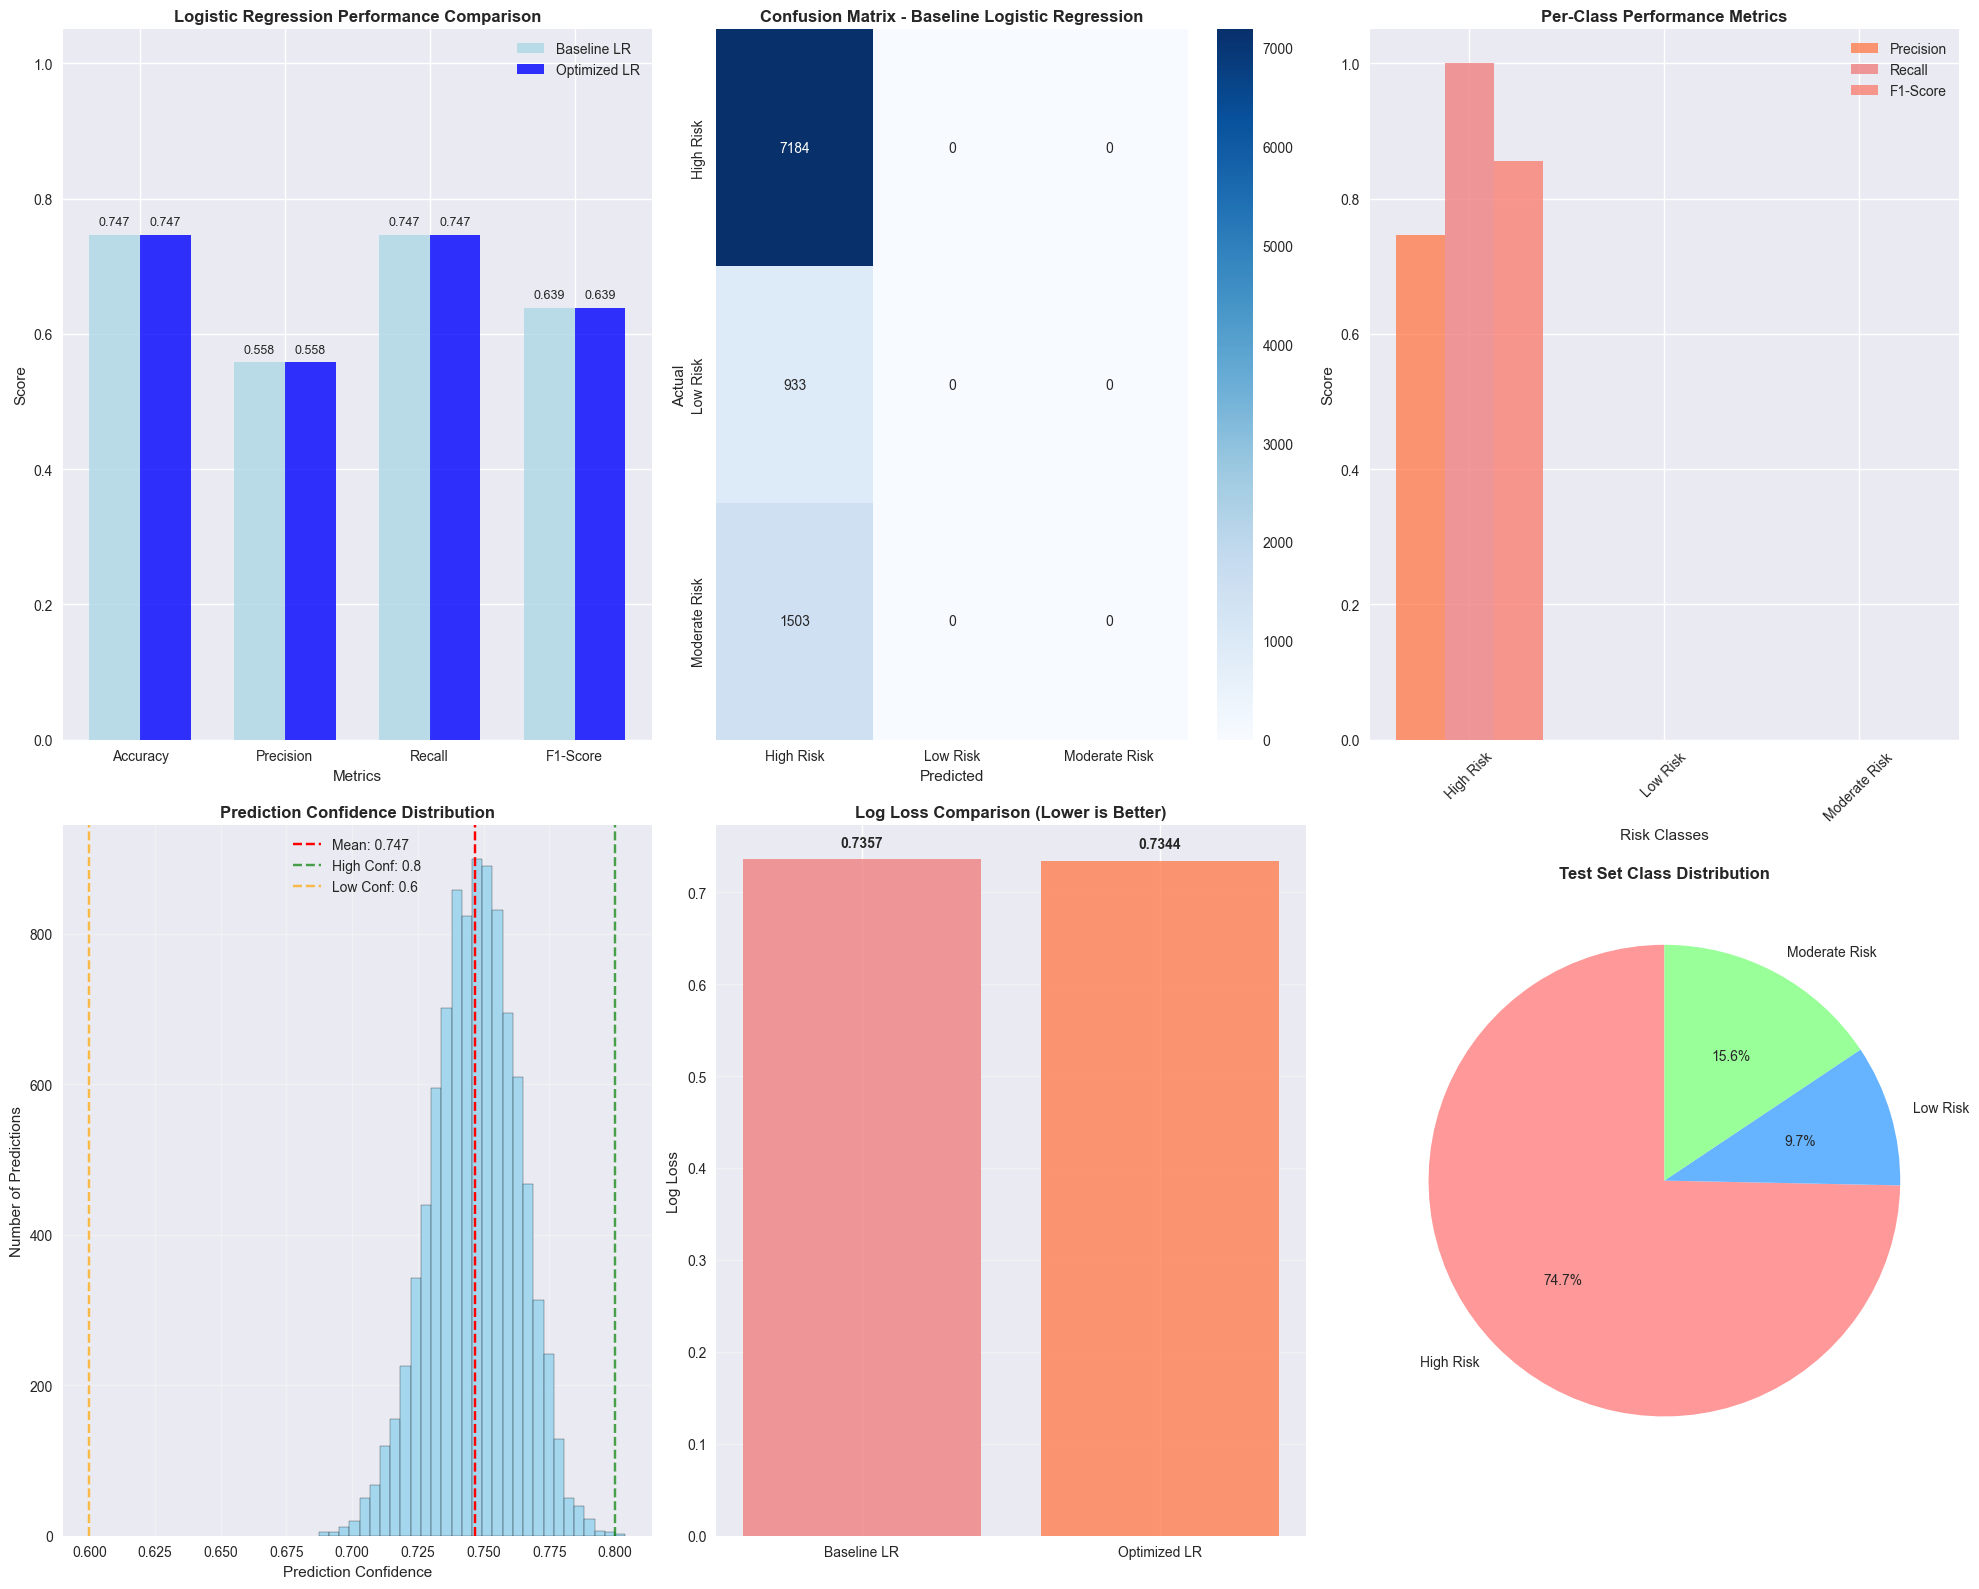

✨ Comprehensive logistic regression evaluation visualizations completed!


In [6]:
# Comprehensive Visualizations for Logistic Regression
print("=" * 60)
print("LOGISTIC REGRESSION VISUALIZATION DASHBOARD")
print("=" * 60)

# Create a comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 16))

# 1. Model Performance Comparison (Bar Plot)
ax1 = plt.subplot(2, 3, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metrics))
width = 0.35

baseline_scores = [baseline_accuracy, baseline_precision, baseline_recall, baseline_f1]
optimized_scores = [best_lr_accuracy, best_lr_precision, best_lr_recall, best_lr_f1]

bars1 = ax1.bar(x_pos - width/2, baseline_scores, width, label='Baseline LR', alpha=0.8, color='lightblue')
bars2 = ax1.bar(x_pos + width/2, optimized_scores, width, label='Optimized LR', alpha=0.8, color='blue')

ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.set_title('Logistic Regression Performance Comparison', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim(0, 1.05)

# Add value labels on bars
for i, (baseline, optimized) in enumerate(zip(baseline_scores, optimized_scores)):
    ax1.text(i - width/2, baseline + 0.01, f'{baseline:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width/2, optimized + 0.01, f'{optimized:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Confusion Matrix Heatmap
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax2)
ax2.set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# 3. Per-Class Performance
ax3 = plt.subplot(2, 3, 3)
class_metrics = []
for i, class_name in enumerate(class_names):
    precision = precision_score(y_test, best_predictions, labels=[i], average=None)[0]
    recall = recall_score(y_test, best_predictions, labels=[i], average=None)[0]
    f1 = f1_score(y_test, best_predictions, labels=[i], average=None)[0]
    class_metrics.append([precision, recall, f1])

class_metrics = np.array(class_metrics)
x_pos = np.arange(len(class_names))
width = 0.25

ax3.bar(x_pos - width, class_metrics[:, 0], width, label='Precision', alpha=0.8, color='coral')
ax3.bar(x_pos, class_metrics[:, 1], width, label='Recall', alpha=0.8, color='lightcoral')
ax3.bar(x_pos + width, class_metrics[:, 2], width, label='F1-Score', alpha=0.8, color='salmon')

ax3.set_xlabel('Risk Classes')
ax3.set_ylabel('Score')
ax3.set_title('Per-Class Performance Metrics', fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(class_names, rotation=45)
ax3.legend()
ax3.set_ylim(0, 1.05)

# 4. Prediction Confidence Distribution
ax4 = plt.subplot(2, 3, 4)
ax4.hist(max_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax4.axvline(np.mean(max_probs), color='red', linestyle='--', 
            label=f'Mean: {np.mean(max_probs):.3f}')
ax4.axvline(high_conf_threshold, color='green', linestyle='--', alpha=0.7,
            label=f'High Conf: {high_conf_threshold}')
ax4.axvline(low_conf_threshold, color='orange', linestyle='--', alpha=0.7,
            label=f'Low Conf: {low_conf_threshold}')
ax4.set_xlabel('Prediction Confidence')
ax4.set_ylabel('Number of Predictions')
ax4.set_title('Prediction Confidence Distribution', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Log Loss Comparison
ax5 = plt.subplot(2, 3, 5)
models = ['Baseline LR', 'Optimized LR']
log_losses = [baseline_log_loss, best_lr_log_loss]
colors = ['lightcoral', 'coral']

bars = ax5.bar(models, log_losses, color=colors, alpha=0.8)
ax5.set_ylabel('Log Loss')
ax5.set_title('Log Loss Comparison (Lower is Better)', fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, loss in zip(bars, log_losses):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{loss:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 6. Class Distribution in Test Set
ax6 = plt.subplot(2, 3, 6)
unique_test, counts_test = np.unique(y_test, return_counts=True)
class_names_test = [class_names[i] for i in unique_test]
colors_pie = ['#ff9999', '#66b3ff', '#99ff99']
wedges, texts, autotexts = ax6.pie(counts_test, labels=class_names_test, autopct='%1.1f%%', 
                                  colors=colors_pie, startangle=90)
ax6.set_title('Test Set Class Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

print("✨ Comprehensive logistic regression evaluation visualizations completed!")


In [7]:
# Feature Coefficient Analysis for Multinomial Logistic Regression
print("\n" + "=" * 60)
print("FEATURE COEFFICIENT ANALYSIS")
print("=" * 60)

# Get coefficients from the best model
coefficients = best_model.coef_
feature_names = X_train.columns
intercepts = best_model.intercept_

print("🔍 MULTINOMIAL LOGISTIC REGRESSION COEFFICIENTS")
print("=" * 50)
print(f"Coefficient matrix shape: {coefficients.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Number of features: {len(feature_names)}")

# Create detailed coefficient analysis
coefficient_analysis = {}
for class_idx, class_name in enumerate(class_names):
    class_coefs = coefficients[class_idx]
    
    # Create DataFrame for this class
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': class_coefs,
        'abs_coefficient': np.abs(class_coefs)
    }).sort_values('abs_coefficient', ascending=False)
    
    coefficient_analysis[class_name] = coef_df
    
    print(f"\n📊 TOP 10 MOST INFLUENTIAL FEATURES FOR {class_name.upper()}:")
    print("-" * 55)
    print(f"{'Rank':<5} {'Feature':<30} {'Coefficient':<12} {'Impact':<10}")
    print("-" * 65)
    
    for i, (_, row) in enumerate(coef_df.head(10).iterrows(), 1):
        impact = "Positive" if row['coefficient'] > 0 else "Negative"
        print(f"{i:<5} {row['feature']:<30} {row['coefficient']:<12.6f} {impact:<10}")

# Overall feature importance (sum of absolute coefficients across all classes)
print(f"\n🎯 OVERALL FEATURE IMPORTANCE ACROSS ALL CLASSES:")
print("=" * 55)

overall_importance = pd.DataFrame({
    'feature': feature_names,
    'total_abs_coefficient': np.sum(np.abs(coefficients), axis=0)
}).sort_values('total_abs_coefficient', ascending=False)

print(f"{'Rank':<5} {'Feature':<30} {'Total Abs Coef':<15} {'Importance':<12}")
print("-" * 70)
for i, (_, row) in enumerate(overall_importance.head(15).iterrows(), 1):
    importance_pct = (row['total_abs_coefficient'] / overall_importance['total_abs_coefficient'].sum()) * 100
    print(f"{i:<5} {row['feature']:<30} {row['total_abs_coefficient']:<15.6f} {importance_pct:<12.2f}%")

# Business insights by categorizing features
print(f"\n💡 BUSINESS INSIGHTS BY FEATURE CATEGORY:")
print("=" * 45)

# Categorize features for business interpretation
supply_chain_categories = {
    'Transportation & Logistics': ['fuel_consumption_rate', 'eta_variation_hours', 'traffic_congestion_level', 
                                  'delivery_time_deviation', 'driver_behavior_score', 'fatigue_monitoring_score'],
    'Warehouse & Inventory': ['warehouse_inventory_level', 'loading_unloading_time', 'handling_equipment_availability'],
    'External Factors': ['weather_condition_severity', 'port_congestion_level', 'customs_clearance_time'],
    'Business Operations': ['order_fulfillment_status', 'shipping_costs', 'supplier_reliability_score', 
                           'lead_time_days', 'historical_demand'],
    'Technology & Monitoring': ['iot_temperature', 'cargo_condition_status', 'delay_probability'],
    'Temporal Factors': ['hour', 'day_of_week', 'month', 'quarter', 'is_weekend'],
    'Geographic': ['vehicle_gps_latitude', 'vehicle_gps_longitude']
}

# Analyze importance by category
category_importance = {}
for category, features in supply_chain_categories.items():
    category_total = 0
    category_features = []
    for feature in features:
        if feature in overall_importance['feature'].values:
            feature_importance = overall_importance[overall_importance['feature'] == feature]['total_abs_coefficient'].iloc[0]
            category_total += feature_importance
            category_features.append((feature, feature_importance))
    
    if category_total > 0:
        category_importance[category] = {
            'total_importance': category_total,
            'percentage': (category_total / overall_importance['total_abs_coefficient'].sum()) * 100,
            'features': sorted(category_features, key=lambda x: x[1], reverse=True)
        }

# Display category analysis
sorted_categories = sorted(category_importance.items(), key=lambda x: x[1]['total_importance'], reverse=True)

for category, info in sorted_categories:
    print(f"\n{category}: {info['percentage']:.2f}% total influence")
    print(f"  Top features in this category:")
    for feature, importance in info['features'][:3]:  # Show top 3 features per category
        feature_pct = (importance / overall_importance['total_abs_coefficient'].sum()) * 100
        print(f"    • {feature:<25} ({feature_pct:.2f}%)")

# Intercept analysis
print(f"\n📈 INTERCEPT ANALYSIS:")
print("-" * 20)
print("Intercepts represent the baseline log-odds for each class:")
for class_idx, class_name in enumerate(class_names):
    print(f"  {class_name}: {intercepts[class_idx]:.6f}")

print(f"\n🎯 LOGISTIC REGRESSION INSIGHTS FOR SUPPLY CHAIN RISK:")
print("=" * 60)
print("Key findings from coefficient analysis:")
print("1. Features with largest absolute coefficients have strongest impact on predictions")
print("2. Positive coefficients increase the log-odds of that class")
print("3. Negative coefficients decrease the log-odds of that class")
print("4. Coefficient magnitude indicates feature importance for each risk class")
print("5. Use feature importance to prioritize supply chain monitoring efforts")



FEATURE COEFFICIENT ANALYSIS
🔍 MULTINOMIAL LOGISTIC REGRESSION COEFFICIENTS
Coefficient matrix shape: (3, 28)
Number of classes: 3
Number of features: 28

📊 TOP 10 MOST INFLUENTIAL FEATURES FOR HIGH RISK:
-------------------------------------------------------
Rank  Feature                        Coefficient  Impact    
-----------------------------------------------------------------
1     quarter                        -0.097843    Negative  
2     month                          0.074882     Positive  
3     handling_equipment_availability 0.016919     Positive  
4     route_risk_level               0.016349     Positive  
5     shipping_costs                 -0.015970    Negative  
6     day_of_week                    0.014806     Positive  
7     vehicle_gps_latitude           -0.013608    Negative  
8     delay_probability              -0.013419    Negative  
9     driver_behavior_score          0.012609     Positive  
10    cargo_condition_status         0.012077     Positive  



COEFFICIENT VISUALIZATION DASHBOARD


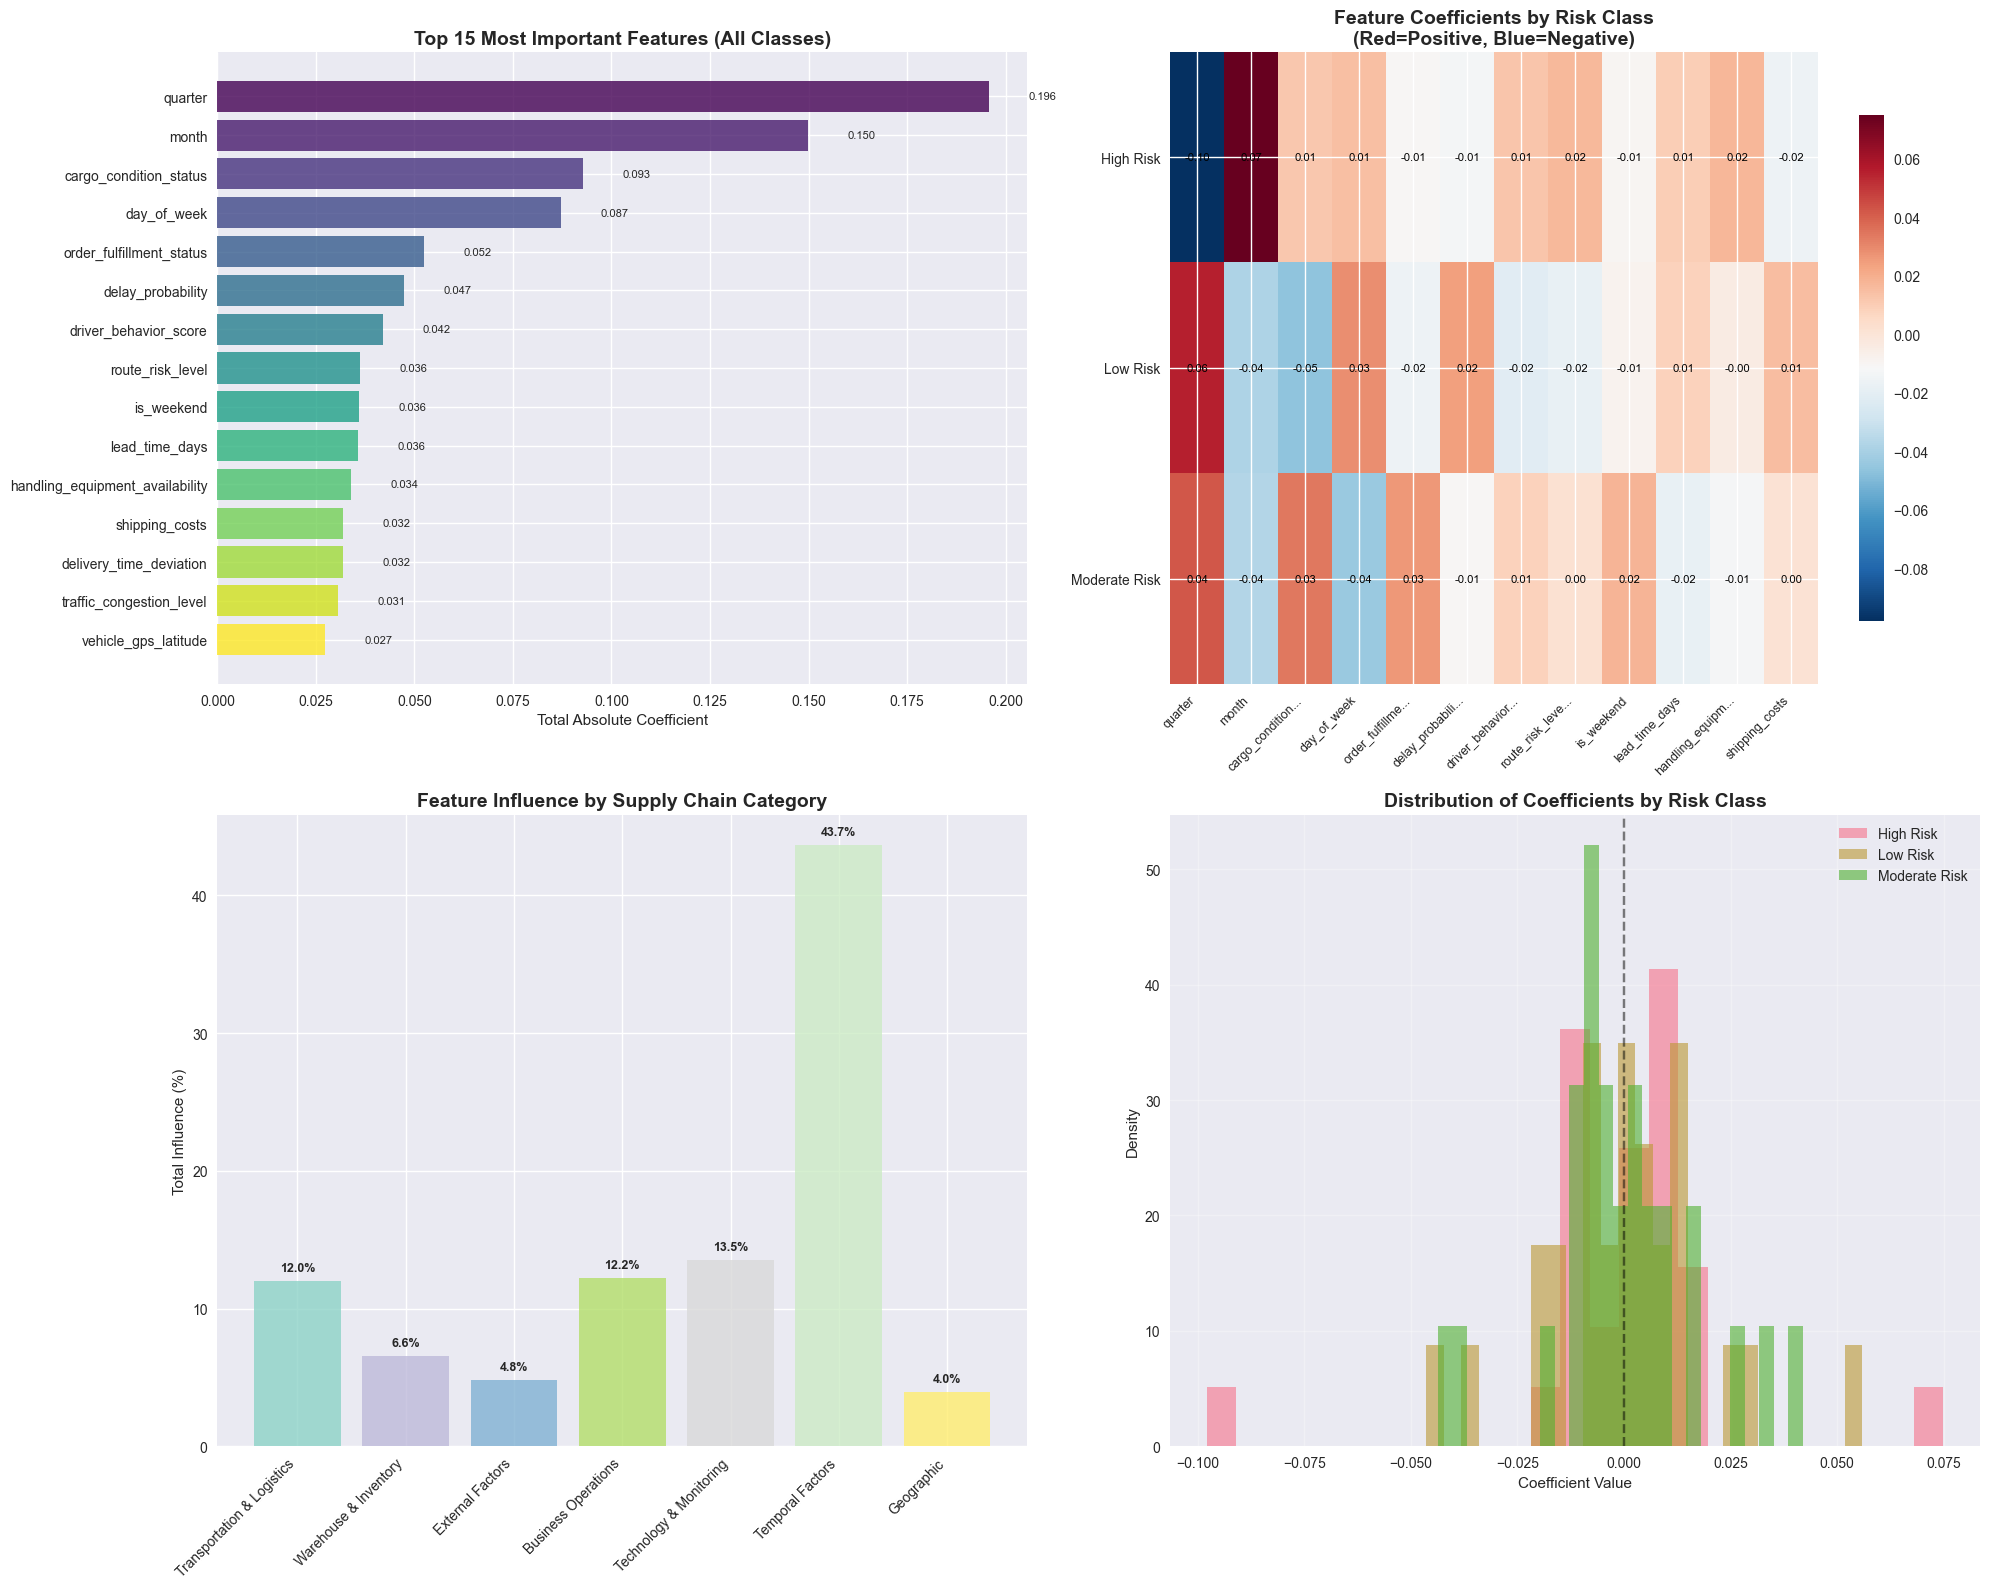


🌟 DETAILED CLASS-SPECIFIC COEFFICIENT ANALYSIS


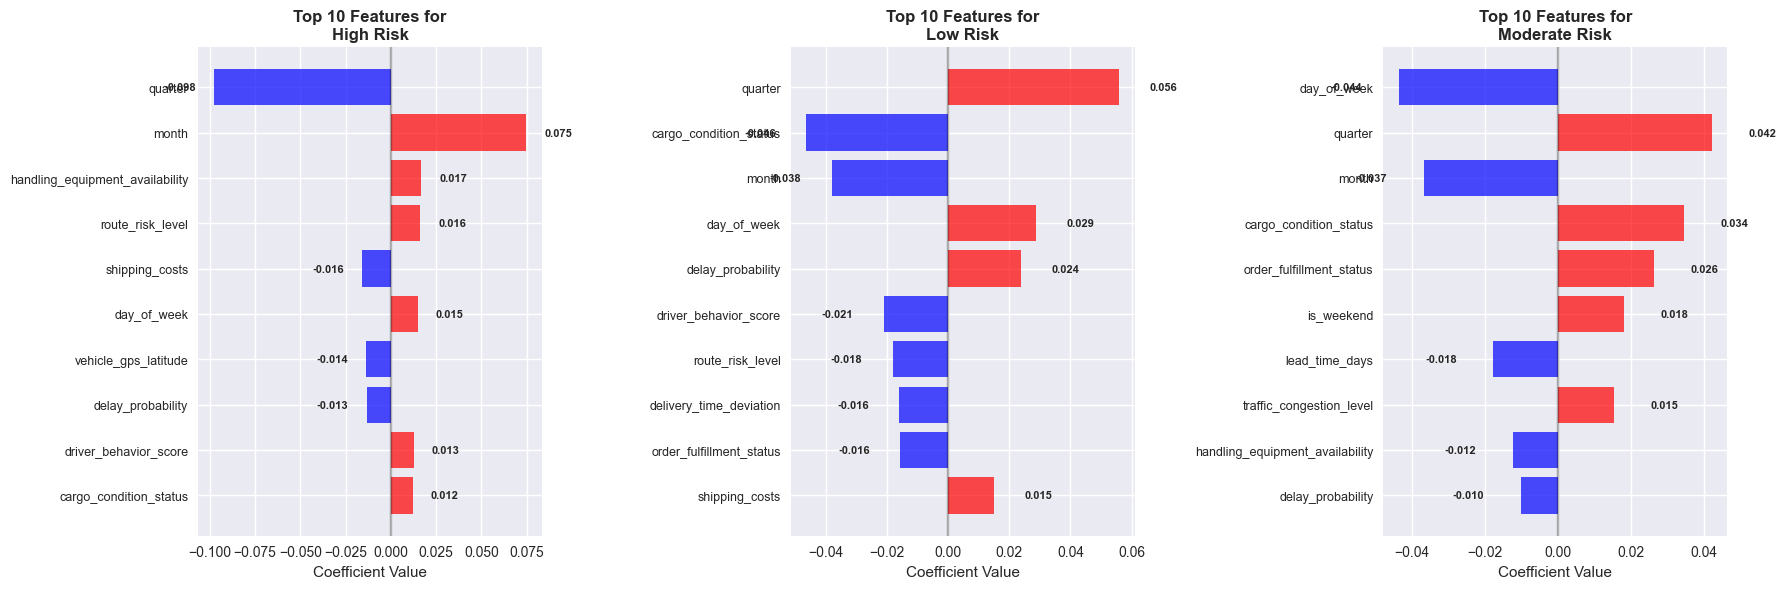

✨ Comprehensive coefficient analysis and visualizations completed!


In [8]:
# Feature Coefficient Visualizations
print("\n" + "=" * 60)
print("COEFFICIENT VISUALIZATION DASHBOARD")
print("=" * 60)

# Create comprehensive coefficient visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Top 15 Overall Feature Importance (Horizontal Bar Chart)
ax1 = axes[0, 0]
top_15_features = overall_importance.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_15_features)))
bars = ax1.barh(range(len(top_15_features)), top_15_features['total_abs_coefficient'], 
                color=colors, alpha=0.8)
ax1.set_yticks(range(len(top_15_features)))
ax1.set_yticklabels(top_15_features['feature'], fontsize=10)
ax1.set_xlabel('Total Absolute Coefficient')
ax1.set_title('Top 15 Most Important Features (All Classes)', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Add value labels on bars
for i, (bar, coef) in enumerate(zip(bars, top_15_features['total_abs_coefficient'])):
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{coef:.3f}', va='center', ha='left', fontsize=8)

# 2. Coefficient Heatmap by Class
ax2 = axes[0, 1]
# Create coefficient matrix for visualization (top 12 features)
top_features_for_heatmap = overall_importance.head(12)['feature'].tolist()
coef_matrix = []
for class_name in class_names:
    class_coefs = []
    for feature in top_features_for_heatmap:
        coef_val = coefficient_analysis[class_name][
            coefficient_analysis[class_name]['feature'] == feature
        ]['coefficient'].iloc[0]
        class_coefs.append(coef_val)
    coef_matrix.append(class_coefs)

coef_matrix = np.array(coef_matrix)
im = ax2.imshow(coef_matrix, cmap='RdBu_r', aspect='auto')
ax2.set_xticks(range(len(top_features_for_heatmap)))
ax2.set_xticklabels([f[:15] + '...' if len(f) > 15 else f for f in top_features_for_heatmap], 
                    rotation=45, ha='right', fontsize=9)
ax2.set_yticks(range(len(class_names)))
ax2.set_yticklabels(class_names, fontsize=10)
ax2.set_title('Feature Coefficients by Risk Class\n(Red=Positive, Blue=Negative)', 
              fontsize=14, fontweight='bold')

# Add colorbar
plt.colorbar(im, ax=ax2, shrink=0.8)

# Add coefficient values as text
for i in range(len(class_names)):
    for j in range(len(top_features_for_heatmap)):
        text = ax2.text(j, i, f'{coef_matrix[i, j]:.2f}', ha="center", va="center", 
                       color="white" if abs(coef_matrix[i, j]) > 0.5 else "black", fontsize=8)

# 3. Category-wise Importance
ax3 = axes[1, 0]
if category_importance:
    categories = list(category_importance.keys())
    category_percentages = [category_importance[cat]['percentage'] for cat in categories]
    
    colors_cat = plt.cm.Set3(np.linspace(0, 1, len(categories)))
    bars_cat = ax3.bar(range(len(categories)), category_percentages, color=colors_cat, alpha=0.8)
    ax3.set_xticks(range(len(categories)))
    ax3.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
    ax3.set_ylabel('Total Influence (%)')
    ax3.set_title('Feature Influence by Supply Chain Category', fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for bar, percentage in zip(bars_cat, category_percentages):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Coefficient Distribution by Class
ax4 = axes[1, 1]
for class_idx, class_name in enumerate(class_names):
    class_coefs = coefficients[class_idx]
    ax4.hist(class_coefs, bins=25, alpha=0.6, label=class_name, density=True)

ax4.set_xlabel('Coefficient Value')
ax4.set_ylabel('Density')
ax4.set_title('Distribution of Coefficients by Risk Class', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.axvline(0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Additional detailed visualization for class-specific coefficients
print("\n🌟 DETAILED CLASS-SPECIFIC COEFFICIENT ANALYSIS")
print("=" * 50)

# Create individual plots for each class
fig, axes = plt.subplots(1, len(class_names), figsize=(18, 6))
if len(class_names) == 1:
    axes = [axes]

for class_idx, class_name in enumerate(class_names):
    ax = axes[class_idx]
    
    # Get top 10 features for this class
    class_data = coefficient_analysis[class_name].head(10)
    
    # Create color map based on positive/negative coefficients
    colors = ['red' if coef > 0 else 'blue' for coef in class_data['coefficient']]
    
    bars = ax.barh(range(len(class_data)), class_data['coefficient'], 
                   color=colors, alpha=0.7)
    
    ax.set_yticks(range(len(class_data)))
    ax.set_yticklabels(class_data['feature'], fontsize=9)
    ax.set_xlabel('Coefficient Value')
    ax.set_title(f'Top 10 Features for\n{class_name}', fontsize=12, fontweight='bold')
    ax.axvline(0, color='black', linestyle='-', alpha=0.3)
    ax.invert_yaxis()
    
    # Add value labels
    for bar, coef in zip(bars, class_data['coefficient']):
        x_pos = bar.get_width() + (0.01 if coef > 0 else -0.01)
        ha = 'left' if coef > 0 else 'right'
        ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{coef:.3f}', 
                va='center', ha=ha, fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("✨ Comprehensive coefficient analysis and visualizations completed!")


In [9]:
# Model Saving and Summary
print("\n" + "=" * 60)
print("MODEL SAVING AND FINAL SUMMARY")
print("=" * 60)

# Save all trained models
print("💾 SAVING ALL TRAINED MODELS")
print("=" * 30)

try:
    # Create directories if they don't exist
    import os
    os.makedirs('models', exist_ok=True)
    os.makedirs('results', exist_ok=True)
    
    # Save all models individually
    print("🔢 Saving Logistic Regression Models:")
    
    # 1. Baseline Logistic Regression
    with open('models/baseline_logistic_regression.pkl', 'wb') as f:
        pickle.dump(lr_baseline, f)
    print("  ✅ Baseline Logistic Regression saved as 'models/baseline_logistic_regression.pkl'")
    
    # 2. Optimized Logistic Regression
    with open('models/optimized_logistic_regression.pkl', 'wb') as f:
        pickle.dump(lr_best, f)
    print("  ✅ Optimized Logistic Regression saved as 'models/optimized_logistic_regression.pkl'")
    
    print("\n🏆 Saving Best Overall Model:")
    
    # 3. Best Overall Model (for easy deployment)
    with open('models/best_logistic_regression_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    print(f"  ✅ Best overall model ({best_model_name}) saved as 'models/best_logistic_regression_model.pkl'")
    
    print("\n📊 Saving Analysis Results:")
    
    # Save model comparison results
    comparison_df.to_csv('results/logistic_regression_comparison.csv', index=False)
    print("  ✅ Model comparison results saved as 'results/logistic_regression_comparison.csv'")
    
    # Save overall feature importance
    overall_importance.to_csv('results/logistic_regression_feature_importance.csv', index=False)
    print("  ✅ Feature importance analysis saved as 'results/logistic_regression_feature_importance.csv'")
    
    # Save coefficient analysis for each class
    for class_name, coef_df in coefficient_analysis.items():
        filename = f'results/coefficients_{class_name.lower().replace(" ", "_")}.csv'
        coef_df.to_csv(filename, index=False)
        print(f"  ✅ {class_name} coefficients saved as '{filename}'")
    
    # Save model parameters for reproducibility
    model_params = {
        'baseline_lr_params': lr_baseline.get_params(),
        'optimized_lr_params': lr_best.get_params(),
        'best_model_name': best_model_name,
        'removed_features': ['disruption_likelihood_score'],  # Track removed leaky features
        'random_state': 42,
        'hyperparameter_search': {
            'method': 'RandomizedSearchCV',
            'n_iter': 30,
            'cv_folds': 3,
            'scoring': 'f1_weighted'
        }
    }
    
    import json
    with open('results/logistic_regression_parameters.json', 'w') as f:
        # Convert numpy types to native Python types for JSON serialization
        def convert_types(obj):
            if hasattr(obj, 'item'):
                return obj.item()
            elif hasattr(obj, 'tolist'):
                return obj.tolist()
            return obj
        
        serializable_params = {}
        for key, value in model_params.items():
            if isinstance(value, dict):
                serializable_params[key] = {k: convert_types(v) for k, v in value.items()}
            else:
                serializable_params[key] = convert_types(value)
        
        json.dump(serializable_params, f, indent=2)
    print("  ✅ Model parameters saved as 'results/logistic_regression_parameters.json'")
    
    print(f"\n🎉 ALL MODELS SAVED SUCCESSFULLY!")
    print("=" * 35)
    
except Exception as e:
    print(f"❌ Error saving models: {e}")

print(f"\n🎉 MULTINOMIAL LOGISTIC REGRESSION - FINAL RESULTS")
print("=" * 60)

print(f"📊 BEST PERFORMING MODEL: {best_model_name}")
print(f"   • F1-Score: {best_f1_score:.4f}")
print(f"   • Model Type: Multinomial Logistic Regression")
print(f"   • Regularization (C): {best_model.C:.6f}")
print(f"   • Penalty: {best_model.penalty}")
print(f"   • Solver: {best_model.solver}")
if best_model.penalty == 'elasticnet':
    print(f"   • L1 Ratio: {best_model.l1_ratio:.3f}")
print(f"   • Converged: {best_model.n_iter_[0] < best_model.max_iter}")

print(f"\n🎯 KEY FINDINGS:")
print("=" * 15)
print(f"1. {best_model_name} achieved F1-score of {best_f1_score:.4f}")
print(f"2. Top 3 most influential features: {', '.join(overall_importance.head(3)['feature'].tolist())}")
print(f"3. Model provides probabilistic predictions for risk assessment")
print(f"4. Feature coefficients reveal linear relationships with risk classes")

improvement = best_lr_f1 - baseline_f1
print(f"5. Hyperparameter tuning improved performance by {improvement:+.4f} F1-score")

print(f"\n🚀 NEXT STEPS:")
print("=" * 12)
print("1. Deploy the best model for real-time risk assessment")
print("2. Monitor model performance and retrain periodically")
print("3. Use coefficient analysis for feature engineering")
print("4. Implement probability thresholds for decision making")
print("5. Consider ensemble methods combining with tree-based models")

print(f"\n📁 FILES GENERATED:")
print("=" * 17)
print("📂 Models Directory:")
print("  • baseline_logistic_regression.pkl - Baseline model")
print("  • optimized_logistic_regression.pkl - Hyperparameter-tuned model")
print("  • best_logistic_regression_model.pkl - Best model for deployment")
print("\n📂 Results Directory:")
print("  • logistic_regression_comparison.csv - Model performance comparison")
print("  • logistic_regression_feature_importance.csv - Overall feature importance")
print("  • coefficients_[class].csv - Class-specific coefficient analysis")
print("  • logistic_regression_parameters.json - All hyperparameters for reproducibility")
print("\n📂 Root Directory:")
print("  • label_encoder.pkl - Label encoder for class mapping")
print("  • standard_scaler.pkl - Feature scaler for preprocessing")

print(f"\n🎯 MODEL INVENTORY SUMMARY:")
print("=" * 25)
print("✅ 2 Complete Models Saved:")
print("   1️⃣ Baseline Multinomial Logistic Regression")
print("   2️⃣ Optimized Multinomial Logistic Regression (RandomizedSearchCV)")
print("   🏆 Best Overall Model (for production deployment)")

print(f"\n✨ Multinomial Logistic Regression analysis completed successfully!")
print("🎯 Supply chain risk classification models are ready for deployment!")
print("📊 Use coefficient analysis to understand feature impact on risk predictions!")



MODEL SAVING AND FINAL SUMMARY
💾 SAVING ALL TRAINED MODELS
🔢 Saving Logistic Regression Models:
  ✅ Baseline Logistic Regression saved as 'models/baseline_logistic_regression.pkl'
  ✅ Optimized Logistic Regression saved as 'models/optimized_logistic_regression.pkl'

🏆 Saving Best Overall Model:
  ✅ Best overall model (Baseline Logistic Regression) saved as 'models/best_logistic_regression_model.pkl'

📊 Saving Analysis Results:
  ✅ Model comparison results saved as 'results/logistic_regression_comparison.csv'
  ✅ Feature importance analysis saved as 'results/logistic_regression_feature_importance.csv'
  ✅ High Risk coefficients saved as 'results/coefficients_high_risk.csv'
  ✅ Low Risk coefficients saved as 'results/coefficients_low_risk.csv'
  ✅ Moderate Risk coefficients saved as 'results/coefficients_moderate_risk.csv'
  ✅ Model parameters saved as 'results/logistic_regression_parameters.json'

🎉 ALL MODELS SAVED SUCCESSFULLY!

🎉 MULTINOMIAL LOGISTIC REGRESSION - FINAL RESULTS
📊 BES